In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
import shap

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import scipy.sparse as sp
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import create_optimizer

Num GPUs Available:  1


## Data import & cleaning

In [3]:
# Import data
df = pd.read_csv('glassdoor.csv', low_memory=False)

# Remove rows with null values in our predictor and target variable columns
df = df.dropna(subset=['PROs', 'CONs', 'Outlook Value'])

# Remove unnecessary columns
columns_to_remove = ['CUSIP', 'ISIN', 'SEDOL', 'As Of Date', 'Logo', 'Author Country', 
                     'Date Updated', 'Company Industry Id', 'Company Sector Id', 'Job Ending Year', 'Description', 'Not Helpful Count']
df = df.drop(columns=columns_to_remove, errors='ignore')  # Avoid errors if a column doesn't exist

# Convert 'Date Added' into a datetime format
df['Date Added'] = pd.to_datetime(df['Date Added'].str[:8], format='%Y%m%d')

# Remove duplicate reviews
df = df.drop_duplicates(subset=['Review Url'])

print(df.shape)
df.head()

(999943, 41)


,Ticker Symbol,Entity Name,Unique ID,Review Url,Company,Author Title,Author Location,Summary,PROs,CONs,...,Length of Employment,Company Website,Date Added,Company Name,Sector,Industry,GICS Sector,GICS Industry,ICB Industry,ICB Sector
0,nasdaq:expi,https://www.glassdoor.com?employer_id=907965,18120620,https://www.glassdoor.com/Reviews/Employee-Rev...,eXp Realty,Agent,"San Jose, CA","Awesome place, awesome people",Low costs and endless opportunities,I guess not having a singular location that ev...,...,2.0,https://exprealty.com/,2024-05-19,eXp Realty,NaN,NaN,Real Estate,Real Estate Management & Development,NaN,NaN
1,nyse:anf,https://www.glassdoor.com?employer_id=6756,18121092,https://www.glassdoor.com/Reviews/Employee-Rev...,Abercrombie & Fitch,Sales Representative,"New Albany, OH",experience,environment was fun and enjoyable,high turnover rate and toxic employees,...,0.0,www.abercrombie.com,2024-05-19,Abercrombie & Fitch,Consumer Services,General Retailers,Consumer Discretionary,Specialty Retail,Consumer Discretionary,Consumer Products and Services
2,nyse:cof,https://www.glassdoor.com?employer_id=3736,18121269,https://www.glassdoor.com/Reviews/Employee-Rev...,Capital One,Finance Analyst,"Plano, TX",Life at Cap1,"Work life balance is really nice, work is real...","some weeks are stressful, can go over 40-50 hours",...,1.0,www.capitalonecareers.com,2024-05-19,Capital One,Financials,Financial Services,Financial,Consumer Finance,Financials,Banks
3,private:spacex,https://www.glassdoor.com?employer_id=40371,18119803,https://www.glassdoor.com/Reviews/Employee-Rev...,SpaceX,Electrical Engineer,"Redmond, WA",Great place to work when you’re young,Great experience and the work is interesting i...,You won’t have much of a life outside of work ...,...,2.0,www.spacex.com,2024-05-19,SpaceX,Industrials,Aerospace & Defense,NaN,NaN,Industrials,Industrial Goods and Services
4,private:statefarm,https://www.glassdoor.com?employer_id=2990,18119819,https://www.glassdoor.com/Reviews/Employee-Rev...,State Farm,Insurance Sales Representative,"Vicksburg, MS",Insurance Sales Representative,Schedule M-F 930-430\nBenefits \nClosed all ho...,Base salary is low and if don’t make your comm...,...,2.0,https://www.statefarm.com/careers,2024-05-19,State Farm,NaN,NaN,NaN,NaN,NaN,NaN


## Exploratory analysis

In [4]:
# Print the number of distinct values for various fields
distinct_values = df[['Company', 'Author Title', 'Author Location', 'Industry']].nunique()
print("Number of distinct values in each field:")
print(distinct_values)

Number of distinct values in each field:
Company             50879
Author Title       127957
Author Location     23201
Industry               39
dtype: int64


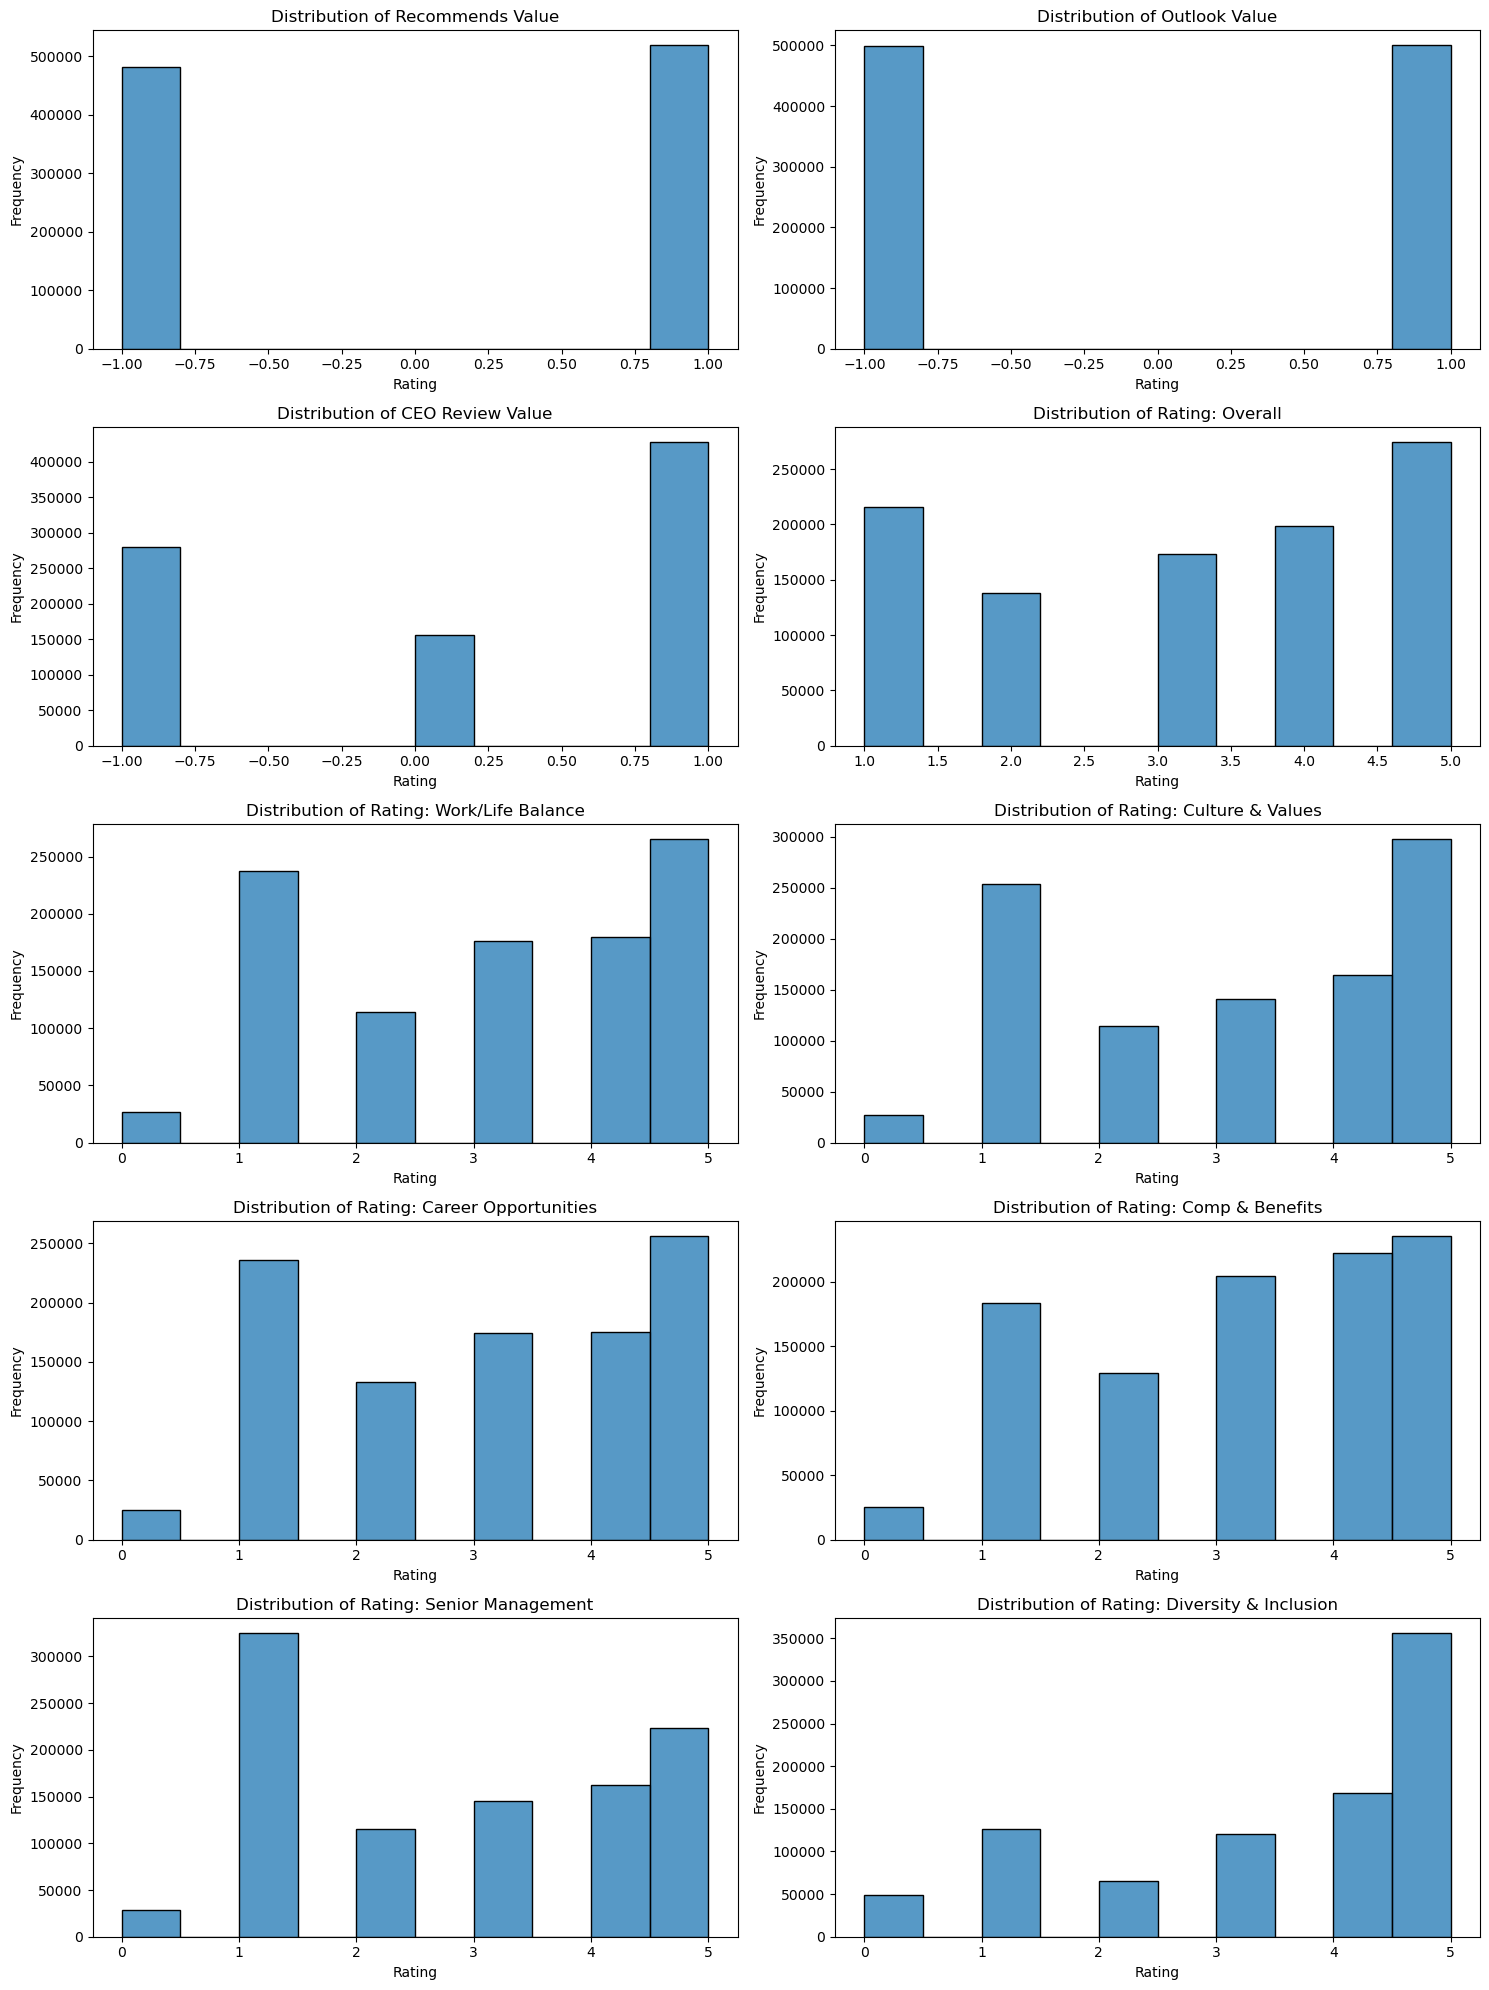

In [5]:
# Plot distributions of ratings columns

# Define the rating columns
rating_columns = [
    'Recommends Value', 'Outlook Value', 'CEO Review Value', 
    'Rating: Overall', 'Rating: Work/Life Balance', 'Rating: Culture & Values', 
    'Rating: Career Opportunities', 'Rating: Comp & Benefits', 
    'Rating: Senior Management', 'Rating: Diversity & Inclusion'
]

# Plot histograms for each rating column
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.ravel()  # Flatten the array for easier iteration

for i, col in enumerate(rating_columns):
    sns.histplot(df[col], bins=10, kde=False, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('Rating')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

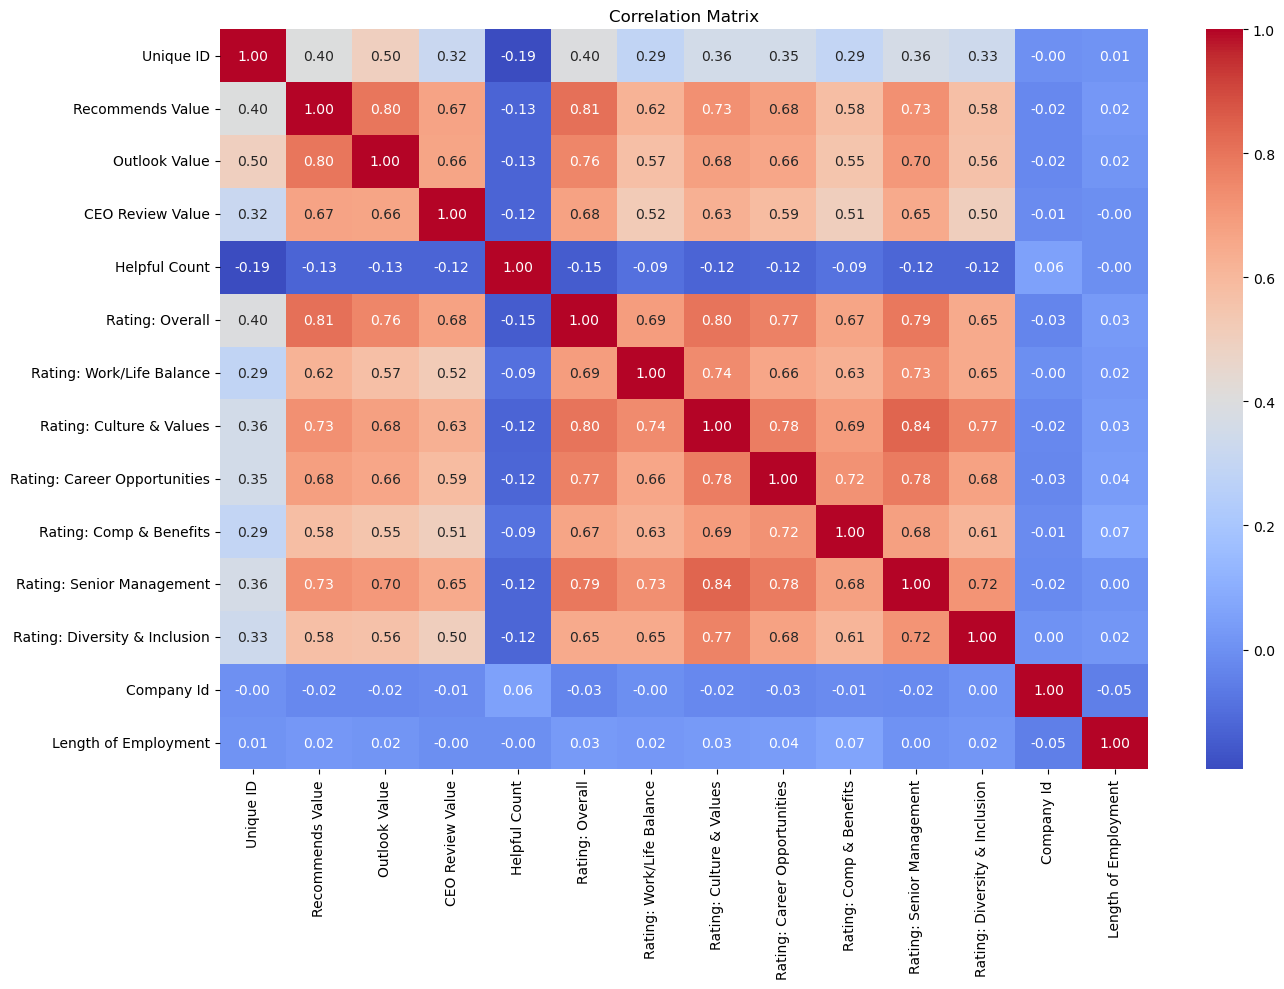

In [6]:
# Compute correlation matrix for numerical columns
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

# Generate a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Baseline models

In [7]:
# Text preprocessing

nltk.download('stopwords')

# Function to clean text data
def clean_text(text):
    # Remove non-printable characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # Remove punctuations and numbers
    text = re.sub(r'[\W_]+', ' ', text, flags=re.UNICODE)
    # Convert text to lowercase
    text = text.lower()
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning function to both 'PROs' and 'CONs' columns
df['PROs_clean'] = df['PROs'].apply(clean_text)
df['CONs_clean'] = df['CONs'].apply(clean_text)

# Combine cleaned text columns
df['combined_text'] = df['PROs_clean'] + " " + df['CONs_clean']

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1),
                                   stop_words=stopwords.words('english'),
                                   max_features=1000)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dylan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Set the predictor as the combined text of PROs and CONs
predictor = df['combined_text']

# Vectorize text data
X = tfidf_vectorizer.fit_transform(predictor)

In [9]:
# Encode the target variable
y = df['Outlook Value'].apply(lambda x: 1 if x == 1 else 0) # Make target robust to changes in case we add a neutral outlook option in the future

### Logistic Regression baseline

In [36]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Initialize and train Logistic Regression model
lr_model = LogisticRegression(max_iter=10000, class_weight='balanced') # Use balanced class weights to handle potential class imbalance
lr_model.fit(X_train, y_train)

# Predictions
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# Evaluate the model
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Training Classification Report:\n", classification_report(y_train, y_train_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

# Check for overfitting
if accuracy_score(y_train, y_train_pred) > accuracy_score(y_test, y_test_pred):
    print("Model may be overfitting.")
else:
    print("Model performance is consistent.")

Training Accuracy: 0.7720936000330686
Test Accuracy: 0.7718752250126008
Training Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.75      0.77    375088
           1       0.76      0.80      0.78    374869

    accuracy                           0.77    749957
   macro avg       0.77      0.77      0.77    749957
weighted avg       0.77      0.77      0.77    749957

Test Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.75      0.77    124868
           1       0.76      0.80      0.78    125118

    accuracy                           0.77    249986
   macro avg       0.77      0.77      0.77    249986
weighted avg       0.77      0.77      0.77    249986

Model may be overfitting.


In [38]:
# Large dataset, so we need to reduce the number of samples for SHAP
background = shap.sample(X_train, 10000)

# Initialize the SHAP Explainer
explainer = shap.KernelExplainer(lr_model.predict_proba, background, link="logit")

# Compute SHAP values on a subset of the data to reduce computational load 
X_sample = shap.sample(X_train, 100)
shap_values = explainer.shap_values(X_sample)

# Convert sparse matrix to dense array
X_sample_dense = X_sample.toarray() if sp.issparse(X_sample) else X_sample

# Plot the SHAP summary plot
shap.summary_plot(shap_values[1], X_sample_dense, feature_names=tfidf_vectorizer.get_feature_names_out())

  0%|          | 0/100 [09:56<?, ?it/s]

KeyboardInterrupt



### Random Forest baseline

In [33]:
# Initialize and train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10) # Limit the depth to prevent overfitting and reduce overhead
rf_model.fit(X_train, y_train)

# Predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Evaluate the model
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Training Classification Report:\n", classification_report(y_train, y_train_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

# Check for overfitting
if accuracy_score(y_train, y_train_pred) > accuracy_score(y_test, y_test_pred):
    print("Model may be overfitting.")
else:
    print("Model performance is consistent.")

ValueError: could not convert string to float: 'onboarding process office place with mall next to it overtime bonuses salary attitude many programs and process'

### XGBoost baseline

In [13]:
# Initialize and train XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, max_depth=10, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predictions
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
print("XGBoost Training Accuracy:", accuracy_score(y_train, y_train_pred_xgb))
print("XGBoost Test Accuracy:", accuracy_score(y_test, y_test_pred_xgb))
print("XGBoost Training Classification Report:\n", classification_report(y_train, y_train_pred_xgb))
print("XGBoost Test Classification Report:\n", classification_report(y_test, y_test_pred_xgb))

# Check for overfitting
if accuracy_score(y_train, y_train_pred_xgb) > accuracy_score(y_test, y_test_pred_xgb):
    print("XGBoost Model may be overfitting.")
else:
    print("XGBoost Model performance is consistent.")

XGBoost Training Accuracy: 0.7956869527186226
XGBoost Test Accuracy: 0.7700671237589305
XGBoost Training Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.75      0.79    375088
           1       0.77      0.84      0.80    374869

    accuracy                           0.80    749957
   macro avg       0.80      0.80      0.80    749957
weighted avg       0.80      0.80      0.80    749957

XGBoost Test Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.73      0.76    124868
           1       0.75      0.81      0.78    125118

    accuracy                           0.77    249986
   macro avg       0.77      0.77      0.77    249986
weighted avg       0.77      0.77      0.77    249986

XGBoost Model may be overfitting.


## Prepare GloVe embeddings for RNN

In [14]:
# Load the GloVe vectors

def load_glove_embeddings(path):
    embeddings_index = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split(' ')
            word = values[0]
            try:
                vector = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = vector
            except ValueError:
                print(f"Error converting values for word: {word}")
                continue
    return embeddings_index

# Path to the GloVe file
glove_path = 'glove.840B.300d.txt'
glove_embeddings = load_glove_embeddings(glove_path)
print(f"Loaded {len(glove_embeddings)} word vectors.")

Loaded 2196016 word vectors.


## RNN with LSTM

In [15]:
# Create subset of the data due to size (1 million rows of text features)
use_sample = True
sample_fraction = 0.5

# Decide whether to use a sample or the full dataset
if use_sample:
    df_used = df.sample(frac=sample_fraction, random_state=42)
else:
    df_used = df

In [16]:
# Set the predictor and target variables
predictor = df_used['combined_text']
target = df_used['Outlook Value'].apply(lambda x: 1 if x == 1 else 0)

In [17]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(predictor, target, test_size=0.25, random_state=42)

In [18]:
# Initialize tokenizer
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Determine the maximum sequence length
max_seq_length = max(len(x) for x in X_train_seq)

# Pad sequences to the same length
X_train_padded = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_seq_length)

In [19]:
# Create an embedding matrix for the words we have in the dataset
num_words = len(tokenizer.word_index) + 1 # Add 1 because of reserved 0 index for padding
embedding_dim = 300  # Dimensionality of GloVe embeddings

# Prepare embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None: # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

print(f"Shape of embedding matrix: {embedding_matrix.shape}")

Shape of embedding matrix: (100023, 300)


In [20]:
# Initialize the model
model = Sequential()

# Add the Embedding layer
model.add(Embedding(input_dim=num_words, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_seq_length, 
                    trainable=True))

# Add the first LSTM layer
model.add(LSTM(128, return_sequences=True))

# Add batch normalization
model.add(BatchNormalization())

# Add dropout for regularization
model.add(Dropout(0.5)) # Can increase dropout to reduce overfitting

# Add the second LSTM layer
model.add(LSTM(128)) # Can decrease units to reduce overfitting

# Add dropout for regularization
model.add(Dropout(0.5))

# Add the output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2793, 300)         30006900  
                                                                 
 lstm (LSTM)                 (None, 2793, 128)         219648    
                                                                 
 batch_normalization (BatchN  (None, 2793, 128)        512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2793, 128)         0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

Epoch 1/10
2198/2198 [==============================] - ETA: 0s - loss: 0.4411 - accuracy: 0.7971
Epoch 1: val_loss improved from inf to 0.39878, saving model to best_model.h5
2198/2198 [==============================] - 1321s 599ms/step - loss: 0.4411 - accuracy: 0.7971 - val_loss: 0.3988 - val_accuracy: 0.8205
Epoch 2/10
2198/2198 [==============================] - ETA: 0s - loss: 0.3744 - accuracy: 0.8352
Epoch 2: val_loss improved from 0.39878 to 0.39393, saving model to best_model.h5
2198/2198 [==============================] - 1289s 586ms/step - loss: 0.3744 - accuracy: 0.8352 - val_loss: 0.3939 - val_accuracy: 0.8231
Epoch 3/10
2198/2198 [==============================] - ETA: 0s - loss: 0.3354 - accuracy: 0.8552
Epoch 3: val_loss did not improve from 0.39393
2198/2198 [==============================] - 1308s 595ms/step - loss: 0.3354 - accuracy: 0.8552 - val_loss: 0.4089 - val_accuracy: 0.8135
Epoch 4/10
2198/2198 [==============================] - ETA: 0s - loss: 0.2996 - accu

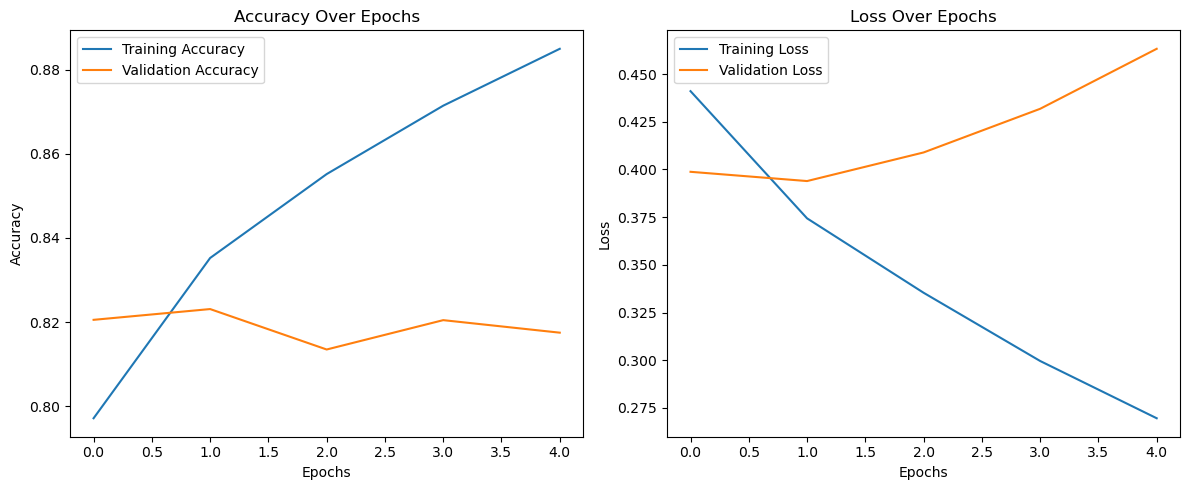

977/977 [==============================] - 216s 221ms/step - loss: 0.3963 - accuracy: 0.8221
Test Loss: 0.3963400721549988
Test Accuracy: 0.8220540285110474


In [21]:
# Setup callbacks for early stopping and best model checkpointing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Fit the model
history = model.fit(X_train_padded, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.25,
                    callbacks=callbacks,
                    verbose=1)

# Print model training and validation progress
def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_history(history)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, batch_size=128)

# Print out the loss and accuracy on test data
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

## RNN with LSTM + Attention layer

In [22]:
# Create a custom layer for Attention
class Attention(Layer):
    def __init__(self, return_sequences=True): # return_sequences=True since using with LSTM
        super(Attention, self).__init__()
        self.return_sequences = return_sequences # Indicates whether to return the entire sequence

    def build(self, input_shape): # Initialize the weights
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")

    def call(self, x): # Perform the operations to compute the attention weights
        e = tf.nn.tanh(tf.matmul(x, self.W) + self.b)
        a = tf.nn.softmax(e, axis=1) # Apply softmax to the attention weights
        output = x * a # Multiply the attention weights with the input data
        
        if self.return_sequences: # Return the entire sequence
            return output
        return tf.reduce_sum(output, axis=1)

    def get_config(self): # Required for saving and loading the model
        return {"return_sequences": self.return_sequences}

In [23]:
# Initialize the model
model = Sequential()

# Add the Embedding layer
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_seq_length,
                    trainable=True))

# Add the first LSTM layer
model.add(LSTM(128, return_sequences=True))

# Add batch normalization
model.add(BatchNormalization())

# Add dropout for regularization
model.add(Dropout(0.5))

# Add the Attention layer
model.add(Attention(return_sequences=True))

# Add the second LSTM layer
model.add(LSTM(128))

# Add dropout for regularization
model.add(Dropout(0.5))

# Add the output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2793, 300)         30006900  
                                                                 
 lstm_2 (LSTM)               (None, 2793, 128)         219648    
                                                                 
 batch_normalization_1 (Batc  (None, 2793, 128)        512       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 2793, 128)         0         
                                                                 
 attention (Attention)       (None, 2793, 128)         2921      
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                      

Epoch 1/10
2198/2198 [==============================] - ETA: 0s - loss: 0.4230 - accuracy: 0.8065
Epoch 1: val_loss improved from inf to 0.42010, saving model to best_model_with_attention.h5
2198/2198 [==============================] - 1315s 597ms/step - loss: 0.4230 - accuracy: 0.8065 - val_loss: 0.4201 - val_accuracy: 0.8235
Epoch 2/10
2198/2198 [==============================] - ETA: 0s - loss: 0.3569 - accuracy: 0.8441
Epoch 2: val_loss improved from 0.42010 to 0.38866, saving model to best_model_with_attention.h5
2198/2198 [==============================] - 1291s 587ms/step - loss: 0.3569 - accuracy: 0.8441 - val_loss: 0.3887 - val_accuracy: 0.8281
Epoch 3/10
2198/2198 [==============================] - ETA: 0s - loss: 0.3101 - accuracy: 0.8673
Epoch 3: val_loss did not improve from 0.38866
2198/2198 [==============================] - 1285s 585ms/step - loss: 0.3101 - accuracy: 0.8673 - val_loss: 0.4299 - val_accuracy: 0.8217
Epoch 4/10
2198/2198 [==============================] -

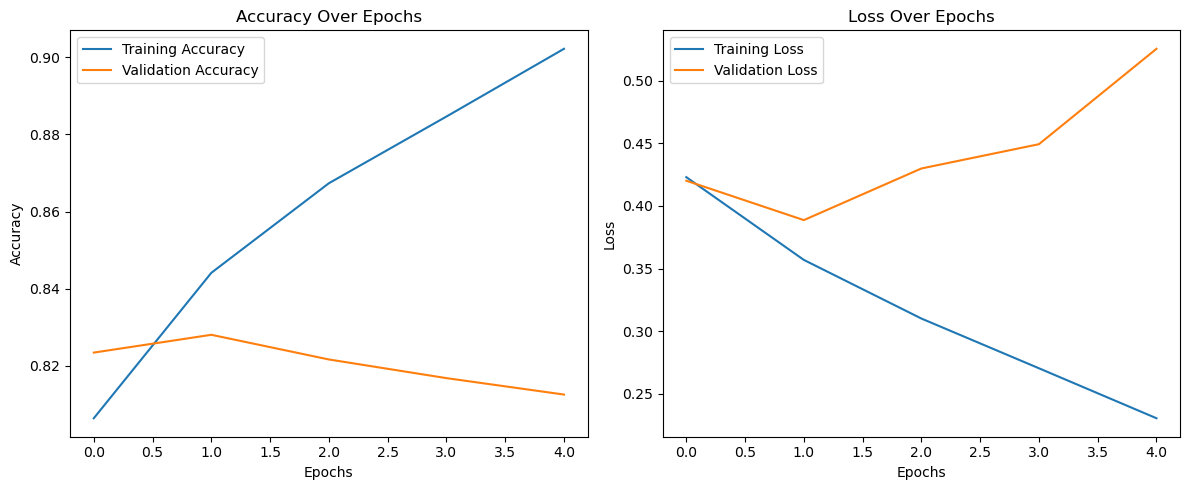

977/977 [==============================] - 217s 222ms/step - loss: 0.3927 - accuracy: 0.8262
Test Loss: 0.39270052313804626
Test Accuracy: 0.8261662721633911


In [24]:
# Setup callbacks for early stopping and best model checkpointing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_model_with_attention.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Fit the model
history = model.fit(X_train_padded, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.25,
                    callbacks=callbacks,
                    verbose=1)

# Print model training and validation progress
def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_history(history)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, batch_size=128)

# Print out the loss and accuracy on test data
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

## DistilBERT implementation

In [25]:
# Load the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [26]:
# Function to encode texts
def encode_texts(texts):
    return tokenizer(texts.to_list(), padding=True, truncation=True, max_length=512, return_tensors="tf")

# Encode the predictor text
encoded_inputs = encode_texts(df_used['combined_text'])

In [27]:
# Adjust labels from 1 and -1 to 1 and 0
df_used['Outlook Value Adjusted'] = df_used['Outlook Value'].apply(lambda x: 1 if x == 1 else 0)

In [28]:
# Convert adjusted labels to TensorFlow format
labels = tf.convert_to_tensor(df_used['Outlook Value Adjusted'].tolist())

# Create TensorFlow dataset
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# Load tensors into the dataset
dataset = tf.data.Dataset.from_tensor_slices((encoded_inputs['input_ids'], encoded_inputs['attention_mask'], labels))
dataset = dataset.map(map_func).batch(32) # Can reduce batch size to save memory

In [29]:
# Create validation set
train_size = int(0.75 * len(dataset))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [30]:
# Set up optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Epoch 1/5
11718/11718 [==============================] - ETA: 0s - loss: 0.3891 - accuracy: 0.8260
Epoch 1: val_loss improved from inf to 0.36945, saving model to best_distilbert_model


INFO:tensorflow:Assets written to: best_distilbert_model\assets


INFO:tensorflow:Assets written to: best_distilbert_model\assets


11718/11718 [==============================] - 5242s 447ms/step - loss: 0.3891 - accuracy: 0.8260 - val_loss: 0.3695 - val_accuracy: 0.8366
Epoch 2/5
11718/11718 [==============================] - ETA: 0s - loss: 0.3382 - accuracy: 0.8539
Epoch 2: val_loss did not improve from 0.36945
11718/11718 [==============================] - 5189s 443ms/step - loss: 0.3382 - accuracy: 0.8539 - val_loss: 0.3748 - val_accuracy: 0.8337
Epoch 3/5
11718/11718 [==============================] - ETA: 0s - loss: 0.2877 - accuracy: 0.8809
Epoch 3: val_loss did not improve from 0.36945
11718/11718 [==============================] - 5158s 440ms/step - loss: 0.2877 - accuracy: 0.8809 - val_loss: 0.4046 - val_accuracy: 0.8279
Epoch 4/5
11718/11718 [==============================] - ETA: 0s - loss: 0.2381 - accuracy: 0.9049Restoring model weights from the end of the best epoch: 1.

Epoch 4: val_loss did not improve from 0.36945
11718/11718 [==============================] - 5156s 440ms/step - loss: 0.2381 - ac

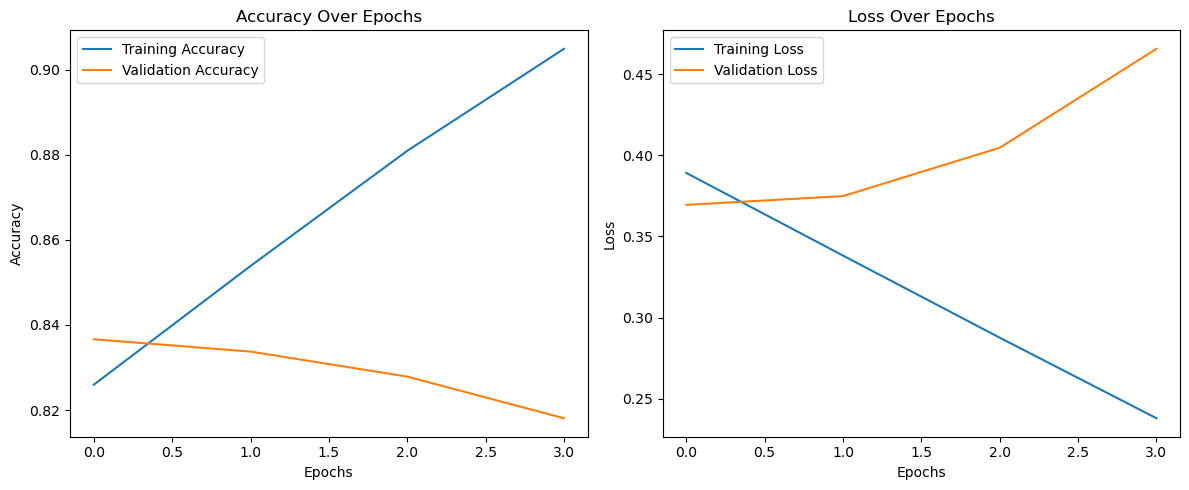

In [31]:
# Setup callbacks for early stopping and best model checkpointing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_distilbert_model', monitor='val_loss', save_best_only=True, verbose=1, save_format='tf')
]

# Fit the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=callbacks,
    verbose=1
)

# Function to plot training and validation progress
def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_history(history)

Epoch 1/5
11718/11718 [==============================] - ETA: 0s - loss: 0.3891 - accuracy: 0.8260
Epoch 1: val_loss improved from inf to 0.36945, saving model to best_distilbert_model


INFO:tensorflow:Assets written to: best_distilbert_model\assets


INFO:tensorflow:Assets written to: best_distilbert_model\assets


11718/11718 [==============================] - 5242s 447ms/step - loss: 0.3891 - accuracy: 0.8260 - val_loss: 0.3695 - val_accuracy: 0.8366
Epoch 2/5
11718/11718 [==============================] - ETA: 0s - loss: 0.3382 - accuracy: 0.8539
Epoch 2: val_loss did not improve from 0.36945
11718/11718 [==============================] - 5189s 443ms/step - loss: 0.3382 - accuracy: 0.8539 - val_loss: 0.3748 - val_accuracy: 0.8337
Epoch 3/5
11718/11718 [==============================] - ETA: 0s - loss: 0.2877 - accuracy: 0.8809
Epoch 3: val_loss did not improve from 0.36945
11718/11718 [==============================] - 5158s 440ms/step - loss: 0.2877 - accuracy: 0.8809 - val_loss: 0.4046 - val_accuracy: 0.8279
Epoch 4/5
11718/11718 [==============================] - ETA: 0s - loss: 0.2381 - accuracy: 0.9049Restoring model weights from the end of the best epoch: 1.

Epoch 4: val_loss did not improve from 0.36945
11718/11718 [==============================] - 5156s 440ms/step - loss: 0.2381 - ac

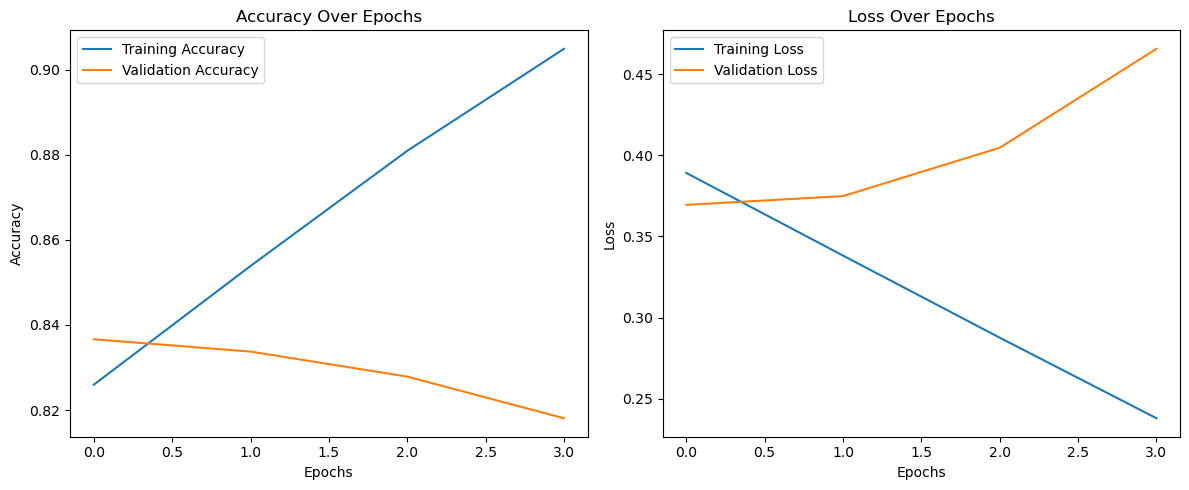

In [ ]:
# Setup callbacks for early stopping and best model checkpointing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_distilbert_model', monitor='val_loss', save_best_only=True, verbose=1, save_format='tf')
]

# Fit the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=callbacks,
    verbose=1
)

# Function to plot training and validation progress
def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_history(history)